**DL for recommendation**

Implement two classical neural network architectures for recommendation: Neural Collaborative Filtering (NeuMF) and a Two-Tower model. Compare these models to the classical Matrix Factorization/BPR baseline. Discuss representational differences, optimization tradeoffs, and performance changes

We built both models using PyTorch

1. **NeuMF:** We implemented the standard Neural Matrix Factorization model (GMF + MLP pathways)
2. **Two-Tower Model:** We built separate user and item towers. The item tower was enhanced by concatenating learned embeddings with Content-Based TF-IDF features (genres/decades)

Both models were trained using own `Dataset` that generates uniform negative samples and optimized via Binary Cross-Entropy over score differences to ensure a fair comparison against our baseline BPR-MF model

In [1]:
import sys
sys.path.append("../src")
sys.path.append("../src/evaluation")
sys.path.append("../src/models")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from utils.data_loader import MovieLensDataLoader
from evaluator import RecommenderEvaluator
from content_based import build_tfidf_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = MovieLensDataLoader()
train, val, test = loader.load_splits()
_, movies, _ = loader.load_raw_data()

n_users = train['user_id'].max() + 1
n_items = train['item_id'].max() + 1

THRESHOLD = 4.0
pos_df = train[train['rating'] >= THRESHOLD]
user_pos_items = pos_df.groupby('user_id')['item_id'].apply(set).to_dict()
user_all_items = train.groupby('user_id')['item_id'].apply(set).to_dict()

Train: 797,758 | Val: 97,383 | Test: 105,068
Loaded 1,000,209 ratings
Loaded 3,883 movies
Loaded 6,040 users


**Dataset for BPR Triplet generation**

To train neural networks for ranking, we cannot just predict ratings. We must generate training triplets: $(User, Positive\_Item, Negative\_Item)$. This `Dataset` class dynamically samples a random interacted item and a random non-interacted item for every epoch

In [2]:
class BPRTripletDataset(Dataset):
    # generates (user, pos_item, neg_item) triplets with uniform negative sampling
    def __init__(self, user_pos_items, n_items, samples_per_epoch):
        self.n_items = n_items
        self.samples_per_epoch = samples_per_epoch

        # filter users with at least 1 positive
        self.users = [u for u, items in user_pos_items.items() if len(items) > 0]
        self.user_pos = {u: list(items) for u, items in user_pos_items.items() if len(items) > 0}
        self.user_pos_set = {u: items for u, items in user_pos_items.items() if len(items) > 0}

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        u = self.users[np.random.randint(len(self.users))]
        pos = self.user_pos[u][np.random.randint(len(self.user_pos[u]))]
        neg = np.random.randint(self.n_items)
        while neg in self.user_pos_set[u]:
            neg = np.random.randint(self.n_items)
        return u, pos, neg

**NeuMF (Neural Matrix Factorization)**
This architecture forces the network to learn two distinct pathways:
1. **GMF** An element-wise product of user and item embeddings 
2. **MLP:** Concatenates user and item embeddings and passes them through hidden layers to capture complex, non-linear interactions

The outputs of both pathways are concatenated and projected to a final scalar score

In [3]:
class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, mlp_dims=[64, 32]):
        super().__init__()
        # generalized MF embeddings
        self.gmf_user = nn.Embedding(n_users, emb_dim)
        self.gmf_item = nn.Embedding(n_items, emb_dim)
        
        # MLP embeddings
        self.mlp_user = nn.Embedding(n_users, emb_dim)
        self.mlp_item = nn.Embedding(n_items, emb_dim)
        
        # MLP hidden layers
        layers = []
        in_dim = emb_dim * 2 # input is user and item concatenated
        for dim in mlp_dims:
            layers.append(nn.Linear(in_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            in_dim = dim
        self.mlp = nn.Sequential(*layers)
        
        # final prediction layer: fuses the GMF and MLP outputs
        self.output = nn.Linear(emb_dim + mlp_dims[-1], 1)
        
        self._init_weights()
    
    def _init_weights(self):
        # embeddings initialization
        for emb in [self.gmf_user, self.gmf_item, self.mlp_user, self.mlp_item]:
            nn.init.normal_(emb.weight, 0, 0.01)
        for m in self.modules(): # linear layer initialization
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, user, item):
        # GMF pathway
        gmf = self.gmf_user(user) * self.gmf_item(item)
        # MLP pathway
        mlp_in = torch.cat([self.mlp_user(user), self.mlp_item(item)], dim=-1)
        mlp = self.mlp(mlp_in)
        # fusion
        out = self.output(torch.cat([gmf, mlp], dim=-1))
        return out.squeeze(-1)

**Two-Tower**
This architecture uses two completely separate neural networks (towers). One encodes the User, the other encodes the Item. 
* We inject the TF-IDF features into the Item Tower, concatenating them with the collaborative item embedding
* Final score is the dot product of the two tower outputs

In [4]:
class TwoTower(nn.Module):

    def __init__(self, n_users, n_items, item_feat_dim, emb_dim=32, tower_dim=64):
        super().__init__()
        # collaborative embeddings for users and items
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        
        # user tower: processes only the collaborative user embedding
        self.user_tower = nn.Sequential(
            nn.Linear(emb_dim, tower_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(tower_dim, tower_dim)
        )
        # item tower: processes the collaborative item embedding and the content features
        self.item_tower = nn.Sequential(
            nn.Linear(emb_dim + item_feat_dim, tower_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(tower_dim, tower_dim)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        # embeddings init
        nn.init.normal_(self.user_emb.weight, 0, 0.01)
        nn.init.normal_(self.item_emb.weight, 0, 0.01)
        for m in self.modules(): # hidden layers init
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def get_user_repr(self, user):
        # extract and transform the user embedding into the final user representation
        return self.user_tower(self.user_emb(user))
    
    def get_item_repr(self, item, item_feat):
        # concatenate the learned item embedding with its static TF-IDF features
        emb = self.item_emb(item)
        combined = torch.cat([emb, item_feat], dim=-1)
        # transform the combined vector into the final item representation
        return self.item_tower(combined)
    
    def forward(self, user, item, item_feat):
        # get final representations from both towers
        u_repr = self.get_user_repr(user)
        i_repr = self.get_item_repr(item, item_feat)
        # compute the dot product between the user and item representations
        return (u_repr * i_repr).sum(dim=-1)

In [5]:
# prepare item features for two-tower
tfidf_matrix, feature_names = build_tfidf_features(movies)
item_feat_tensor = torch.FloatTensor(tfidf_matrix).to(device)
item_feat_dim = tfidf_matrix.shape[1]
print(f"item features: {tfidf_matrix.shape}")

item features: (3953, 31)


**BPR training loop**

We train both networks using the Adam optimizer. Instead of predicting a rating via MSE, we use the Pairwise BPR Loss: 
$$L = -\ln(\sigma(\hat{y}_{ui} - \hat{y}_{uj}))$$

This explicitly forces the network to push the score of the positive item ($\hat{y}_{ui}$) higher than the negative item ($\hat{y}_{uj}$)

In [6]:
def train_model(model, dataset, n_epochs=30, lr=0.001, reg=1e-5, batch_size=2048, model_type="neumf", item_features=None):
    
    # adam + weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    loader_obj = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    
    model.to(device)
    history = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        
        for user, pos, neg in loader_obj:
            user = user.long().to(device)
            pos = pos.long().to(device)
            neg = neg.long().to(device)
            # forward pass: calculate scores for positive and negative items
            if model_type == "twotower":
                # two-tower needs the TF-IDF features injected into the item tower
                pos_feat = item_features[pos]
                neg_feat = item_features[neg]
                pos_score = model(user, pos, pos_feat)
                neg_score = model(user, neg, neg_feat)
            else:
                # NeuMF only needs the ids
                pos_score = model(user, pos)
                neg_score = model(user, neg)
            # Pairwise BPR Loss:
            loss = -torch.log(torch.sigmoid(pos_score - neg_score) + 1e-10).mean()
            
            # backpropagation step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        history.append(avg_loss)
        if epoch % 5 == 0:
            print(f"epoch {epoch:3d}: loss = {avg_loss:.4f}")
    
    print(f"epoch {n_epochs-1:3d}: loss = {history[-1]:.4f}")
    return history

**Inference Wrappers**

Because neural networks process batches of tensors, we wrap them in classes that expose the same `predict_for_user()` interface as our previous models so they integrate cleanly with our `RecommenderEvaluator`

In [7]:
class NeuMFWrapper:
    def __init__(self, model, n_users, n_items):
        self.model = model
        self.n_users = n_users
        self.n_items = n_items
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= self.n_users:
            return []
        self.model.eval()
        with torch.no_grad():
            u = torch.LongTensor([user_id]).to(device)
            items = torch.arange(self.n_items).long().to(device)
            u_exp = u.expand(self.n_items)
            # batch to avoid OOM
            scores = np.zeros(self.n_items)
            bs = 4096
            for i in range(0, self.n_items, bs):
                end = min(i + bs, self.n_items)
                s = self.model(u_exp[i:end], items[i:end])
                scores[i:end] = s.cpu().numpy()
        
        if train_df is not None:
            seen = train_df[train_df['user_id'] == user_id]['item_id'].values
            scores[seen] = -np.inf
        
        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])[::-1]]
        return [(int(i), float(scores[i])) for i in top_k if scores[i] > -np.inf]

class TwoTowerWrapper:
    def __init__(self, model, n_users, n_items, item_features):
        self.model = model
        self.n_users = n_users
        self.n_items = n_items
        self.item_features = item_features
        self.precompute_items()
    
    def precompute_items(self):
        self.model.eval()
        with torch.no_grad():
            items = torch.arange(self.n_items).long().to(device)
            bs = 4096
            reprs = []
            for i in range(0, self.n_items, bs):
                end = min(i + bs, self.n_items)
                r = self.model.get_item_repr(items[i:end], self.item_features[i:end])
                reprs.append(r.cpu().numpy())
            self.item_reprs = np.concatenate(reprs, axis=0)
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= self.n_users:
            return []
        self.model.eval()
        with torch.no_grad():
            u = torch.LongTensor([user_id]).to(device)
            u_repr = self.model.get_user_repr(u).cpu().numpy().flatten()
        
        scores = self.item_reprs @ u_repr
        
        if train_df is not None:
            seen = train_df[train_df['user_id'] == user_id]['item_id'].values
            scores[seen] = -np.inf
        
        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])[::-1]]
        return [(int(i), float(scores[i])) for i in top_k if scores[i] > -np.inf]

In [8]:
# Train NeuMF
n_samples = len(pos_df) * 5
dataset = BPRTripletDataset(user_pos_items, n_items, n_samples)

neumf = NeuMF(n_users, n_items, emb_dim=32, mlp_dims=[64, 32])
t0 = time.time()
neumf_hist = train_model(neumf, dataset, n_epochs=30, lr=0.001, reg=1e-5,model_type="neumf")
neumf_time = time.time() - t0
print(f"NeuMF training time: {neumf_time:.1f}s")

epoch   0: loss = 0.2519
epoch   5: loss = 0.1125
epoch  10: loss = 0.0883
epoch  15: loss = 0.0789
epoch  20: loss = 0.0736
epoch  25: loss = 0.0703
epoch  29: loss = 0.0683
NeuMF training time: 1110.1s


In [9]:
# same as BPR but also returns item features
class TwoTowerDataset(Dataset):
    def __init__(self, user_pos_items, n_items, samples_per_epoch, item_features_np):
        self.n_items = n_items
        self.samples_per_epoch = samples_per_epoch
        self.item_feat = item_features_np
        self.users = [u for u, items in user_pos_items.items() if len(items) > 0]
        self.user_pos = {u: list(items) for u, items in user_pos_items.items() if len(items) > 0}
        self.user_pos_set = {u: items for u, items in user_pos_items.items() if len(items) > 0}

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        u = self.users[np.random.randint(len(self.users))]
        pos = self.user_pos[u][np.random.randint(len(self.user_pos[u]))]
        neg = np.random.randint(self.n_items)
        while neg in self.user_pos_set[u]:
            neg = np.random.randint(self.n_items)
        return u, pos, neg

tt_dataset = TwoTowerDataset(user_pos_items, n_items, n_samples, tfidf_matrix)

In [10]:
# train two-tower
twotower = TwoTower(n_users, n_items, item_feat_dim, emb_dim=32, tower_dim=64)
t0 = time.time()
tt_hist = train_model(twotower, tt_dataset, n_epochs=30, lr=0.001, reg=1e-5, model_type="twotower", item_features=item_feat_tensor)
tt_time = time.time() - t0
print(f"Two-Tower training time: {tt_time:.1f}s")

epoch   0: loss = 0.2041
epoch   5: loss = 0.1042
epoch  10: loss = 0.0955
epoch  15: loss = 0.0924
epoch  20: loss = 0.0898
epoch  25: loss = 0.0867
epoch  29: loss = 0.0853
Two-Tower training time: 1149.1s


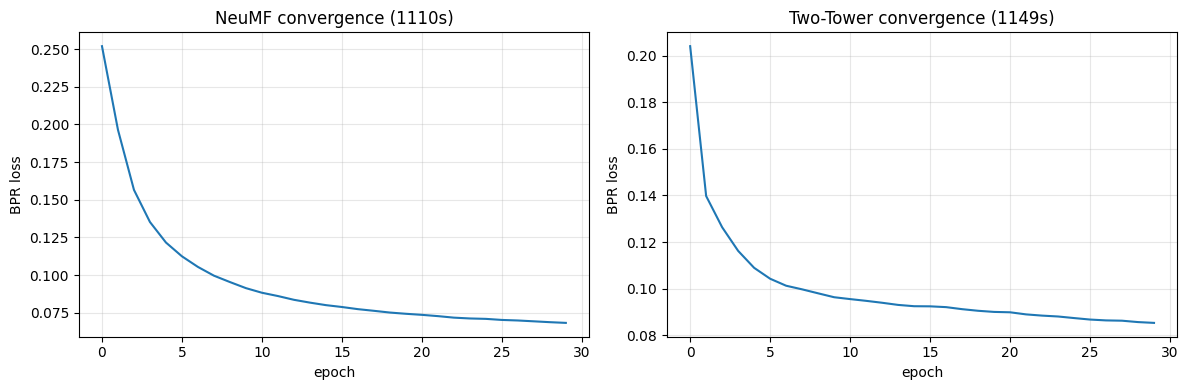

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(neumf_hist)
axes[0].set_title(f"NeuMF convergence ({neumf_time:.0f}s)")
axes[0].set_xlabel("epoch"); axes[0].set_ylabel("BPR loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(tt_hist)
axes[1].set_title(f"Two-Tower convergence ({tt_time:.0f}s)")
axes[1].set_xlabel("epoch"); axes[1].set_ylabel("BPR loss")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../experiments/results/convergence.png", dpi=150)
plt.show()

loss is dropping, thus model is converging and is learning how to widen margin between positive and negative samples

NeuMF minimizes the training objective more effectively than the Two-Tower model. maybe because it is more parametrized, thus more flexible or because two-tower needs to process static tf-idf features alongside embeddings

models took almost the same time to be trained (around 20 mins), much more compared to linear MF approaches

In [12]:
evaluator = RecommenderEvaluator(train, test, k_values=[5, 10, 20])

neumf_wrap = NeuMFWrapper(neumf, n_users, n_items)
tt_wrap = TwoTowerWrapper(twotower, n_users, n_items, item_feat_tensor)

m_neumf = evaluator.evaluate_model(neumf_wrap, model_name="NeuMF")
evaluator.print_metrics(m_neumf, "NeuMF")

NeuMF - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0529
NDCG@10: 0.0619
NDCG@20: 0.0765


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0345
Precision@ 5: 0.0496
Recall@10: 0.0622
Precision@10: 0.0447
Recall@20: 0.1072
Precision@20: 0.0389


Diversity metrics:
Coverage: 0.5682
Popularity bias: 1227.41


In [13]:
m_tt = evaluator.evaluate_model(tt_wrap, model_name="Two-Tower")
evaluator.print_metrics(m_tt, "Two-Tower")

Two-Tower - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0553
NDCG@10: 0.0648
NDCG@20: 0.0800


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0369
Precision@ 5: 0.0522
Recall@10: 0.0666
Precision@10: 0.0477
Recall@20: 0.1124
Precision@20: 0.0410


Diversity metrics:
Coverage: 0.5412
Popularity bias: 1199.32


In [14]:
# Load BPR-MF baseline for comparison
from numba import njit, prange

@njit(fastmath=True)
def bpr_epoch_nb(user_ids, pos_items_flat, pos_offsets, pos_counts,
              n_items, user_factors, item_factors, user_bias, item_bias,
              lr, reg, n_samples):
    loss = 0.0
    for _ in range(n_samples):
        u = np.random.randint(0, len(pos_offsets))
        uid = user_ids[u]
        count = pos_counts[u]
        if count == 0: continue
        offset = pos_offsets[u]
        pi = pos_items_flat[offset + np.random.randint(0, count)]
        ni = np.random.randint(0, n_items)
        for _ in range(10):
            found = False
            for k in range(count):
                if pos_items_flat[offset + k] == ni:
                    found = True; break
            if not found: break
            ni = np.random.randint(0, n_items)
        x_uij = (user_bias[uid] + item_bias[pi] + np.dot(user_factors[uid], item_factors[pi])) - (user_bias[uid] + item_bias[ni] + np.dot(user_factors[uid], item_factors[ni]))
        sig = 1.0 / (1.0 + np.exp(x_uij))
        loss += np.log(1.0 / (1.0 + np.exp(-x_uij)) + 1e-10)
        user_factors[uid] += lr * (sig * (item_factors[pi] - item_factors[ni]) - reg * user_factors[uid])
        item_factors[pi] += lr * (sig * user_factors[uid] - reg * item_factors[pi])
        item_factors[ni] += lr * (-sig * user_factors[uid] - reg * item_factors[ni])
        item_bias[pi] += lr * (sig - reg * item_bias[pi])
        item_bias[ni] += lr * (-sig - reg * item_bias[ni])
    return loss / n_samples

In [15]:
class BPRMF_Baseline:
    def __init__(self, n_users, n_items, n_factors=64, lr=0.01, reg=0.001, n_epochs=40):
        self.n_users, self.n_items = n_users, n_items
        np.random.seed(42)
        self.uf = np.random.normal(0, 0.01, (n_users, n_factors))
        self.itf = np.random.normal(0, 0.01, (n_items, n_factors))
        self.ub = np.zeros(n_users); self.ib = np.zeros(n_items)
        self.lr, self.reg, self.n_epochs, self.nf = lr, reg, n_epochs, n_factors
    
    def fit(self, upi):
        uids, pf, offs, cnts = [], [], [], []
        o = 0
        for uid in range(self.n_users):
            items = list(upi.get(uid, []))
            uids.append(uid); offs.append(o); cnts.append(len(items))
            pf.extend(items); o += len(items)
        uids, pf = np.array(uids, np.int64), np.array(pf, np.int64)
        offs, cnts = np.array(offs, np.int64), np.array(cnts, np.int64)
        ns = len(pf) * 5
        for ep in range(self.n_epochs):
            loss = bpr_epoch_nb(uids, pf, offs, cnts, self.n_items, self.uf, self.itf, self.ub, self.ib, self.lr, self.reg, ns)
            if ep % 10 == 0: print(f"BPR Epoch {ep:3d}: loss={loss:.4f}")
        print(f"BPR Epoch {self.n_epochs-1}: loss={loss:.4f}")
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= self.n_users: return []
        scores = self.ib + self.itf @ self.uf[user_id]
        if train_df is not None:
            scores[train_df[train_df['user_id']==user_id]['item_id'].values] = -np.inf
        tk = np.argpartition(scores, -k)[-k:]
        tk = tk[np.argsort(scores[tk])[::-1]]
        return [(int(i), float(scores[i])) for i in tk if scores[i] > -np.inf]

In [16]:
bpr_base = BPRMF_Baseline(n_users, n_items)
t0 = time.time()
bpr_base.fit(user_pos_items)
bpr_time = time.time() - t0
print(f"BPR-MF training time: {bpr_time:.1f}s")

m_bpr = evaluator.evaluate_model(bpr_base, model_name="BPR-MF")

BPR Epoch   0: loss=-0.3190
BPR Epoch  10: loss=-0.1370
BPR Epoch  20: loss=-0.0693
BPR Epoch  30: loss=-0.0515
BPR Epoch 39: loss=-0.0435
BPR-MF training time: 159.0s


In [17]:
results_df = pd.DataFrame(evaluator.history)
cols = ['Model', 'NDCG@5', 'NDCG@10', 'NDCG@20', 'Recall@10', 'Precision@10', 'Coverage', 'Popularity_Bias']
print("\n" + results_df[[c for c in cols if c in results_df.columns]].round(4).to_string(index=False))


    Model  NDCG@5  NDCG@10  NDCG@20  Recall@10  Precision@10  Coverage  Popularity_Bias
    NeuMF  0.0529   0.0619   0.0765     0.0622        0.0447    0.5682        1227.4075
Two-Tower  0.0553   0.0648   0.0800     0.0666        0.0477    0.5412        1199.3169
   BPR-MF  0.0571   0.0656   0.0828     0.0692        0.0457    0.4542        1099.0416


**Representational Differences**

* **BPR-MF:** Restricted to learning a strict linear relationship. The user's preference for an item is purely the dot product of their latent vectors in a shared space
* **NeuMF:** Expands representational capacity. By separating the linear (GMF) and non-linear (MLP) pathways, it can learn complex interaction surfaces that a simple dot product cannot capture
* **Two-Tower:** Because the towers are independent until the final dot product, we were able to inject TF-IDF genre/decade vectors directly into the item representation. This makes the Two-Tower model hybrid system, bridging collaborative and content signals at the embedding layer rather than blending scores after the fact

**Performance**

* Interestingly, both NeuMF (NDCG@10 = 0.0619) and Two-Tower (NDCG@10 = 0.0648) performed slightly worse than the simple linear BPR-MF baseline (NDCG@10 = 0.0656)
* Neural networks are data-hungry and prone to overfitting on sparse matrices. MovieLens 1M is relatively dense, but the interactions are strictly structural (user ID and item ID). When there is limited side-information to exploit, a simple, heavily regularized linear dot product (MF) often outperforms a highly parameterized MLP
* The Two-Tower model outperformed NeuMF because it wasn't just learning from IDs; it had access to the TF-IDF content features, providing it with a valuable inductive bias that NeuMF lacked

**Optimization and Compute Trade-offs**
The most glaring difference is the computational cost:
* **Training Time:** BPR-MF trained in 159 seconds. The deep learning models took 1110 to 1150 seconds. Deep networks require massive matrix multiplications and expensive backpropagation through multiple layers
* At inference time, NeuMF must compute the full network forward pass (GMF + MLP) for every single User-Item pair. For 6,000 users and 4,000 items, this is roughly 24 million forward passes. It is computationally prohibitive in real world use cases
* While training is slow, the Two-Tower model solves the inference bottleneck. Because the user and item representations are entirely independent, we were able to precompute and cache the item tower embeddings (`precompute_items()`). At inference time, serving recommendations reduces to a simple fast Approximate Nearest Neighbor (ANN) search or dot product, just like MF, making it the only viable DL architecture for web-scale production retrieval

In [18]:
print(f"BPR-MF: {bpr_time:6.1f}s")
print(f"NeuMF: {neumf_time:6.1f}s")
print(f"Two-Tower: {tt_time:6.1f}s")

evaluator.save_results("../experiments/results/dl_comparison.csv")

BPR-MF:  159.0s
NeuMF: 1110.1s
Two-Tower: 1149.1s
